# Import Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Load Data

In [2]:
data = pd.read_csv('COVID-19_Vaccinations_in_the_United_States_County.csv')

/Users/paul.iusztin/Desktop/impact-covid-vaccine-usa/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1201055 entries, 0 to 1201054
Data columns (total 32 columns):
 #   Column                                   Non-Null Count    Dtype  
---  ------                                   --------------    -----  
 0   Date                                     1201055 non-null  object 
 1   FIPS                                     1201055 non-null  object 
 2   MMWR_week                                1201055 non-null  int64  
 3   Recip_County                             1201055 non-null  object 
 4   Recip_State                              1201055 non-null  object 
 5   Series_Complete_Pop_Pct                  1201055 non-null  float64
 6   Series_Complete_Yes                      1201055 non-null  int64  
 7   Series_Complete_12Plus                   1184588 non-null  float64
 8   Series_Complete_12PlusPop_Pct            1184588 non-null  float64
 9   Series_Complete_18Plus                   1201055 non-null  int64  
 10  Series_Complete_18

In [4]:
data.head()

,Date,FIPS,MMWR_week,Recip_County,Recip_State,Series_Complete_Pop_Pct,Series_Complete_Yes,Series_Complete_12Plus,Series_Complete_12PlusPop_Pct,Series_Complete_18Plus,...,SVI_CTGY,Series_Complete_Pop_Pct_SVI,Series_Complete_12PlusPop_Pct_SVI,Series_Complete_18PlusPop_Pct_SVI,Series_Complete_65PlusPop_Pct_SVI,Metro_status,Series_Complete_Pop_Pct_UR_Equity,Series_Complete_12PlusPop_Pct_UR_Equity,Series_Complete_18PlusPop_Pct_UR_Equity,Series_Complete_65PlusPop_Pct_UR_Equity
0,12/13/2021,12071,50,Lee County,FL,58.4,450202,448034.0,65.5,429908,...,C,12.0,12.0,12.0,12.0,Metro,4.0,4.0,4.0,4.0
1,12/13/2021,21155,50,Marion County,KY,46.9,9040,8951.0,55.2,8457,...,D,15.0,16.0,16.0,16.0,Non-metro,7.0,8.0,8.0,8.0
2,12/13/2021,UNK,50,Unknown County,KY,0.0,143323,142403.0,0.0,136422,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12/13/2021,22099,50,St. Martin Parish,LA,37.8,20194,20142.0,44.8,18979,...,D,14.0,15.0,15.0,15.0,Metro,2.0,3.0,3.0,3.0
4,12/13/2021,08125,50,Yuma County,CO,40.5,4053,4043.0,49.6,3881,...,C,11.0,11.0,12.0,12.0,Non-metro,7.0,7.0,8.0,8.0


# Data Cleaning

In [5]:
# Pick only useful columns.
data = data[[
    'Date',
    'Recip_County',
    'Recip_State',
    'Series_Complete_Pop_Pct',
    'Series_Complete_Yes',
    'Series_Complete_12Plus',
    'Series_Complete_12PlusPop_Pct',
    'Series_Complete_18Plus',
    'Series_Complete_18PlusPop_Pct',
    'Series_Complete_65Plus',
    'Series_Complete_65PlusPop_Pct',
    'Completeness_pct'
]]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1201055 entries, 0 to 1201054
Data columns (total 12 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   Date                           1201055 non-null  object 
 1   Recip_County                   1201055 non-null  object 
 2   Recip_State                    1201055 non-null  object 
 3   Series_Complete_Pop_Pct        1201055 non-null  float64
 4   Series_Complete_Yes            1201055 non-null  int64  
 5   Series_Complete_12Plus         1184588 non-null  float64
 6   Series_Complete_12PlusPop_Pct  1184588 non-null  float64
 7   Series_Complete_18Plus         1201055 non-null  int64  
 8   Series_Complete_18PlusPop_Pct  1201055 non-null  float64
 9   Series_Complete_65Plus         1201055 non-null  int64  
 10  Series_Complete_65PlusPop_Pct  1201055 non-null  float64
 11  Completeness_pct               1201055 non-null  float64
dtypes: float64(6),

In [6]:
data.head()

,Date,Recip_County,Recip_State,Series_Complete_Pop_Pct,Series_Complete_Yes,Series_Complete_12Plus,Series_Complete_12PlusPop_Pct,Series_Complete_18Plus,Series_Complete_18PlusPop_Pct,Series_Complete_65Plus,Series_Complete_65PlusPop_Pct,Completeness_pct
0,12/13/2021,Lee County,FL,58.4,450202,448034.0,65.5,429908,67.5,195622,87.1,95.0
1,12/13/2021,Marion County,KY,46.9,9040,8951.0,55.2,8457,57.8,2648,81.1,94.0
2,12/13/2021,Unknown County,KY,0.0,143323,142403.0,0.0,136422,0.0,37898,0.0,94.0
3,12/13/2021,St. Martin Parish,LA,37.8,20194,20142.0,44.8,18979,46.6,5762,68.6,95.0
4,12/13/2021,Yuma County,CO,40.5,4053,4043.0,49.6,3881,53.4,1327,70.9,95.0


In [7]:
# Let's cast all Series data into float64.
series_columns = [c for c in data.columns if 'Series' in c]
data[series_columns] = data[series_columns].astype(np.float64)
# Convert Date to datetime.
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1201055 entries, 0 to 1201054
Data columns (total 12 columns):
 #   Column                         Non-Null Count    Dtype         
---  ------                         --------------    -----         
 0   Date                           1201055 non-null  datetime64[ns]
 1   Recip_County                   1201055 non-null  object        
 2   Recip_State                    1201055 non-null  object        
 3   Series_Complete_Pop_Pct        1201055 non-null  float64       
 4   Series_Complete_Yes            1201055 non-null  float64       
 5   Series_Complete_12Plus         1184588 non-null  float64       
 6   Series_Complete_12PlusPop_Pct  1184588 non-null  float64       
 7   Series_Complete_18Plus         1201055 non-null  float64       
 8   Series_Complete_18PlusPop_Pct  1201055 non-null  float64       
 9   Series_Complete_65Plus         1201055 non-null  float64       
 10  Series_Complete_65PlusPop_Pct  1201055 non-null  float

In [8]:
data.head()

,Date,Recip_County,Recip_State,Series_Complete_Pop_Pct,Series_Complete_Yes,Series_Complete_12Plus,Series_Complete_12PlusPop_Pct,Series_Complete_18Plus,Series_Complete_18PlusPop_Pct,Series_Complete_65Plus,Series_Complete_65PlusPop_Pct,Completeness_pct
0,2021-12-13,Lee County,FL,58.4,450202.0,448034.0,65.5,429908.0,67.5,195622.0,87.1,95.0
1,2021-12-13,Marion County,KY,46.9,9040.0,8951.0,55.2,8457.0,57.8,2648.0,81.1,94.0
2,2021-12-13,Unknown County,KY,0.0,143323.0,142403.0,0.0,136422.0,0.0,37898.0,0.0,94.0
3,2021-12-13,St. Martin Parish,LA,37.8,20194.0,20142.0,44.8,18979.0,46.6,5762.0,68.6,95.0
4,2021-12-13,Yuma County,CO,40.5,4053.0,4043.0,49.6,3881.0,53.4,1327.0,70.9,95.0


In [9]:
print(f'Total nmber of rows: {len(data)}')

Total nmber of rows: 1201055


In [10]:
print('Are there any null rows for the essential reference data?')
print(f'Date: {data["Date"].isnull().sum()}')
print(f'Recip_County: {data["Recip_County"].isnull().sum()}')
print(f'Recip_State: {data["Recip_State"].isnull().sum()}')

Are there any null rows for the essential reference data?
Date: 0
Recip_County: 0
Recip_State: 0


Ok. So we are good. Probably only the `Series_Complete_12Plus` columns have null values as we saw in the `info` panel.

In [11]:
data['Series_Complete_12Plus'][data['Series_Complete_12Plus'].isnull()]

102       NaN
167       NaN
190       NaN
205       NaN
320       NaN
           ..
1200529   NaN
1200653   NaN
1200837   NaN
1200847   NaN
1200962   NaN
Name: Series_Complete_12Plus, Length: 16467, dtype: float64

We have to be aware about those `NaN` values when we group the data on states.

# Create Time Series by State

Let's see all the existing states.

In [12]:
states = data['Recip_State'].unique()
states.sort()
print(f'A total of {len(states)} states:')
print(states)

A total of 60 states:
['AK' 'AL' 'AR' 'AS' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'FM' 'GA' 'GU'
 'HI' 'IA' 'ID' 'IL' 'IN' 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MH' 'MI' 'MN'
 'MO' 'MP' 'MS' 'MT' 'NC' 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK'
 'OR' 'PA' 'PR' 'PW' 'RI' 'SC' 'SD' 'TN' 'TX' 'UNK' 'UT' 'VA' 'VI' 'VT'
 'WA' 'WI' 'WV' 'WY']


In [13]:
# Let's see the Date Range
dates = data['Date'].unique()
dates.sort()
print(f'First: {dates[0]}')
print(f'Last: {dates[-1]}')
print(f'A total of: {len(dates)}')
print(dates)

First: 2020-12-13T00:00:00.000000000
Last: 2021-12-13T00:00:00.000000000
A total of: 366
['2020-12-13T00:00:00.000000000' '2020-12-14T00:00:00.000000000'
 '2020-12-15T00:00:00.000000000' '2020-12-16T00:00:00.000000000'
 '2020-12-17T00:00:00.000000000' '2020-12-18T00:00:00.000000000'
 '2020-12-19T00:00:00.000000000' '2020-12-20T00:00:00.000000000'
 '2020-12-21T00:00:00.000000000' '2020-12-22T00:00:00.000000000'
 '2020-12-23T00:00:00.000000000' '2020-12-24T00:00:00.000000000'
 '2020-12-25T00:00:00.000000000' '2020-12-26T00:00:00.000000000'
 '2020-12-27T00:00:00.000000000' '2020-12-28T00:00:00.000000000'
 '2020-12-29T00:00:00.000000000' '2020-12-30T00:00:00.000000000'
 '2020-12-31T00:00:00.000000000' '2021-01-01T00:00:00.000000000'
 '2021-01-02T00:00:00.000000000' '2021-01-03T00:00:00.000000000'
 '2021-01-04T00:00:00.000000000' '2021-01-05T00:00:00.000000000'
 '2021-01-06T00:00:00.000000000' '2021-01-07T00:00:00.000000000'
 '2021-01-08T00:00:00.000000000' '2021-01-09T00:00:00.000000000'
 

We can see that they start from the half of december of 2020 to the half of december of 2021 with a frequency of 2 days. So we have 1 year of data.

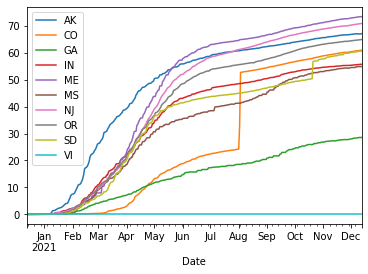

In [14]:
parsed_groups = dict()
state_groups = data.groupby('Recip_State')
for idx, (group_name, group) in enumerate(state_groups):
    # In a state there are multiple counties. Aggregate those with a mean operator.
    # Values from the same counties will have the same date.
    # This operation will also set the Date as the index.
    state_group = group.groupby('Date').mean()
    # Fill possible NaN values with the edges.
    state_group.fillna('bfill', inplace=True)
    state_group.fillna('ffill', inplace=True)
    
    assert state_group.isnull().values.any().item() is False
    
    parsed_groups[group_name] = state_group
    
    if idx % 6 == 0:
        state_group['Series_Complete_18PlusPop_Pct'].plot(label=group_name)
    plt.legend()

# Let's See Some Trends

In [15]:
data = list(parsed_groups.values())[0]['Series_Complete_18PlusPop_Pct']
decomposition = sm.tsa.seasonal_decompose(data, model='additive')

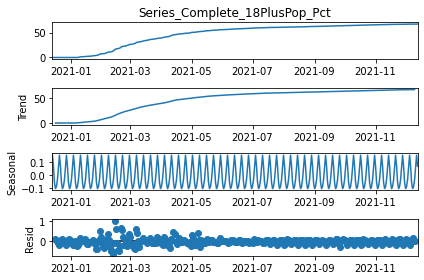

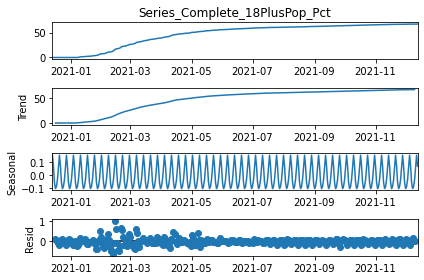

In [16]:
decomposition.plot()